In [385]:
from hpcp_loader_for_softdtw import *
from imp import reload

from torch.utils.data import DataLoader
import models.BaseSPPNet as models
reload(models)
from config import DefaultConfig, opt
from tqdm import tqdm
import torch
from utility import *
import matplotlib.pyplot as plt
import json
import torch.nn.functional as F
from torch.nn.parallel.data_parallel import DataParallel
import os
import pandas as pd
import seaborn as sns
import resource
import librosa
import numpy as np

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device_ids = [0,1]

In [386]:
rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
torch.backends.cudnn.benchmark = True  # cudnn有很多种并行计算卷积的算法，
resource.setrlimit(resource.RLIMIT_NOFILE, (2048, rlimit[1]))

In [387]:
@torch.no_grad()
def val_quick(softdtw, dataloader):
    softdtw.eval()
    softdtw.model.eval()
    labels = []
    temp = []
    count = -1
    for ii, (data, label) in tqdm(enumerate(dataloader)):
        labels.append(label)
    labels = torch.cat(labels, dim=0)
    N = labels.shape[0]
    dis2d = np.zeros((N, N))
    for ii, (data, label) in tqdm(enumerate(dataloader)):
        data = data.cuda()
        count += 1
        if count == 0:
            temp.append((data, count))
        else:
            for i in range(len(temp)):
                dis = softdtw.multi_compute_s(data, temp[i][0]).data.cpu().numpy()
                dis2d[temp[i][1]][count], dis2d[count][temp[i][1]] = -dis, -dis
            temp.append((data, count))

    MAP, top10, rank1 = calc_MAP(dis2d[0:labels.shape[0], 0:labels.shape[0]], labels)
    print(f'MAP:{MAP}\ttop10:{top10}\trank1:{rank1}')
    softdtw.train()
    softdtw.model.train()
    return MAP

In [389]:
model_name = 'NeuralDTW_CNN_Mask_dilation_SPP6_3'

model = getattr(models, model_name)(None)

model.to('cuda:0')
torch.multiprocessing.set_sharing_strategy('file_system')

In [321]:
# val_data = CQT(mode=f'gdoras_test_1', out_length=400)
# val_dataloader = DataLoader(val_data, 1, shuffle=False, num_workers=1)

# model.load('/S3/DAA/jcy/SCNN/check_points/<class \'models.BaseSPPNet.NeuralDTW_CNN_Mask_dilation_SPP6\'>mask/0927_21:55:22.pth')
# # jcy学长最优模型

# print(f'-----------------test_{1}-----------------')
# # map1 = val_quick(model, val_dataloader)

In [ ]:
val_data = CQT(mode=f'gdoras_test_1', out_length=400)
val_dataloader = DataLoader(val_data, 1, shuffle=False, num_workers=1)

model.load('./check_points/<class \'models.BaseSPPNet.NeuralDTW_CNN_Mask_dilation_SPP6\'>mask/1023_20:44:12.pth')
# gdoras dataset 自己训练的

print(f'-----------------test_{1}-----------------')

In [390]:
data_list = []
label_list = []
for idx, (x, y) in enumerate(val_data):
    x = x.cuda().unsqueeze(0)
    data_list.append((x, y))
    label_list.append(y)

In [392]:
songa, songb = 3,2

print(label_list[songa], label_list[songb])

seqa = model.model.forward(data_list[songa][0])
seqb = model.model.forward(data_list[songb][0])

pic_list = []
for i in range(1):
    pic_list.append(model.metric(seqa, seqb)[0])

41034 41034


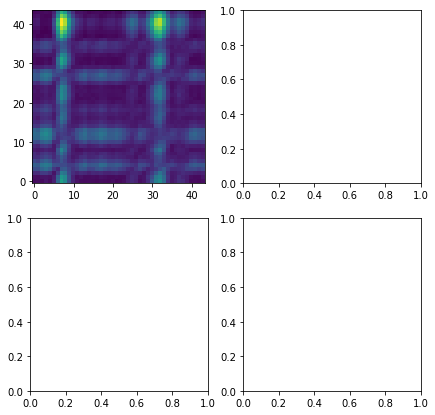

In [394]:
fig, ax = plt.subplots(2,2, figsize=(7,7))
ax = ax.flatten()
for i in range(1):
    ax[i].imshow(pic_list[i].detach().cpu().numpy(), origin='lower')

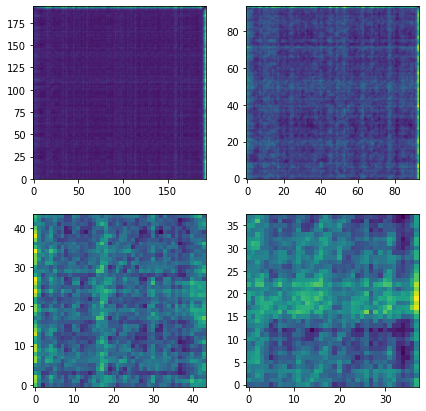

In [102]:
fig, ax = plt.subplots(2,2, figsize=(7,7))
ax = ax.flatten()
for i in range(4):
    ax[i].imshow(pic_list[i].detach().cpu().numpy(), origin='lower')

In [ ]:
for number in range(1, 6):
    val_data = CQT(mode=f'gdoras_test_{number}', out_length=400)
    val_dataloader = DataLoader(val_data, 1, shuffle=False, num_workers=1)

    model.load('./check_points/<class \'models.BaseSPPNet.NeuralDTW_CNN_Mask_dilation_SPP6\'>mask/1023_20:44:12.pth')

    print(f'-----------------test_{number}-----------------')
    map1 = val_quick(model, val_dataloader)